## Deep Symmetric Autoencoder

This autoencoder is developed with 14 layers, where the second 7 is a mirror of the first 7.
I did not impose a sparseness penalty on the encoded part of the network, and instead chose to force the network to compress the values into a much smaller vector.
We do a series of 3x3 conv followed by pooling, and on the decoding step, we do 3x3 conv transpose (and set the stride according to whether we are trying to mirror a pool).
This model also used relatively few filters (4, 8, 16, 32), which was done mainly to allow this model to fit in GPU memory along with the other models we were training (colorization).
We suspect we could achieve better performance with more filters, but this would also reduce the compression factor that this autoencoder exhibits.

In [1]:
%matplotlib inline 
import os
import numpy as np
import tensorflow as tf
import pymongo as pm
import gridfs
import cPickle
import scipy.signal as signal
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, trange

### Data and plotting functions
#### Training curve

In [2]:
port = 24444
# host = '10.138.0.2'
host = 'localhost'
dbname = 'hw2'
conn = pm.MongoClient(port = port, host = host)
collname = 'deep_sym_ae'
coll = conn[dbname][collname + '.files']

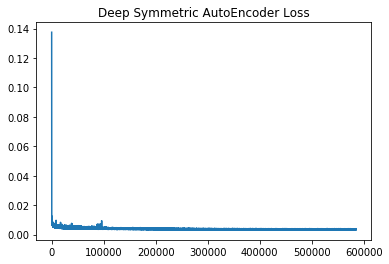

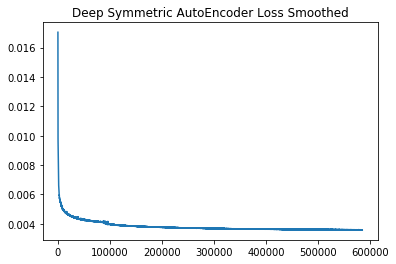

In [3]:
def get_losses(exp_id, collname='deep_sym_ae', dbname='hw2'):
    """
    Gets all loss entries from the database and concatenates them into a vector
    """
    coll = conn[dbname][collname + '.files']
    q_train = {'exp_id' : exp_id, 'train_results' : {'$exists' : True}}
    return np.array([_r['loss'] 
                     for r in coll.find(q_train, projection = ['train_results']) 
                     for _r in r['train_results']])

def smooth(arr, size=300):
    return signal.convolve(arr, np.ones(size)/size, mode='valid')

def plt_reg_and_smoothed(arr, title_prefix):
    smoothed = smooth(arr)
    for values, title_suffix in zip([arr, smoothed], ['', ' Smoothed']):
        plt.plot(values)
        plt.title(title_prefix + title_suffix)
        plt.show()

args = ['cifar-3']
plt_reg_and_smoothed(get_losses(*args), 'Deep Symmetric AutoEncoder Loss')

## Validation images

The images come out looking quite reasonable based on what we would expect from an autoencoder. The images look like blurred versions of the ground truth images, which makes sense if we think of autoencoders as compression/decompression functions.

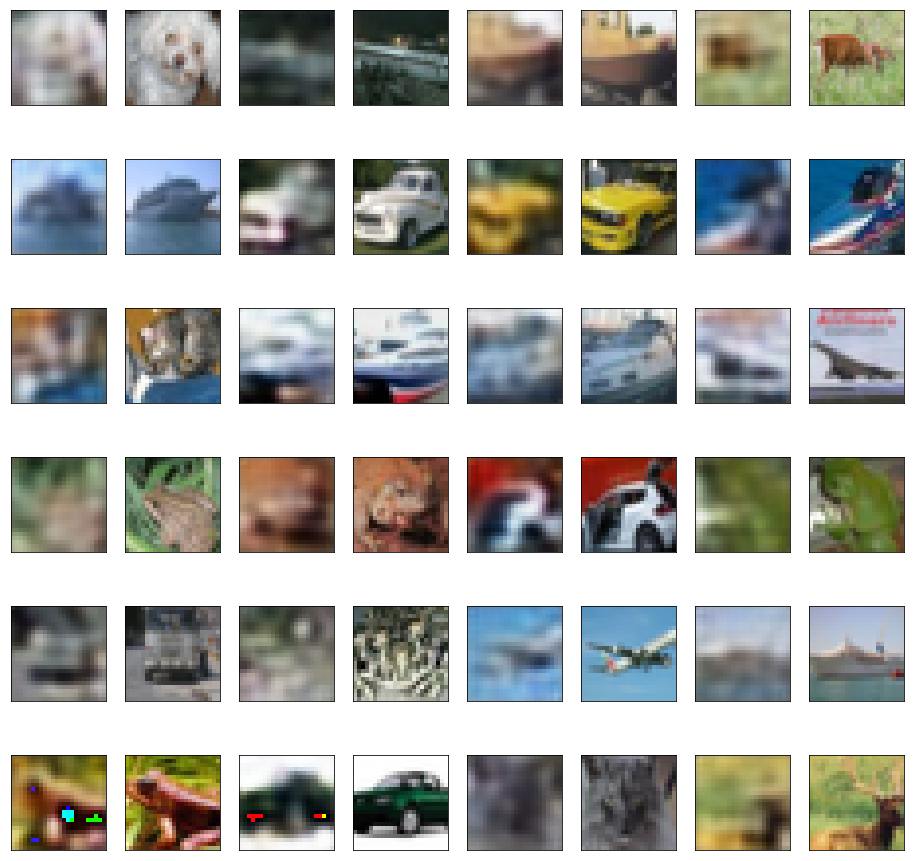

In [4]:
def get_validation_images(exp_id):
    """
    Gets the validation images from the database
    """
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates' : {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results'])
    results = results = [val_steps[i] for i in range(val_steps.count())]
    data = results[0]['validation_results']['valid0']
    pred = np.array([data['result'][0]['pred'] 
            for i in range(val_steps.count())])
    gt = np.array([data['result'][0]['gt'] 
            for i in range(val_steps.count())])
    return {'gt': gt, 'pred': pred}

def plot_validation_images(exp_id, n_images = 24):
    '''
    Plots n_images images in a grid. The ground truth image is on the left 
    and the prediction is on the right.
    '''
    imgs = get_validation_images(exp_id)
    fig = plt.figure(figsize=(16, 16))
    for i in range(n_images):
        pred = np.reshape(imgs['pred'][0,i], [24, 24, 3])
        plt.subplot(n_images/4,n_images/3,1 + i*2)
        plt.imshow(pred, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        gt = np.reshape(imgs['gt'][0,i], [24, 24, 3])
        plt.subplot(n_images/4,n_images/3,2 + i*2)
        plt.imshow(gt, cmap='gray')
        ax = plt.gca()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
plot_validation_images('cifar-1-val1')

#### Neural analysis functions

In [5]:
def get_neural_validation_data(exp_id, collname='deep_sym_ae', dbname='hw2'):
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    return results

def get_classification_validation_data(exp_id, collname='deep_sym_ae', dbname='hw2'):
    port = 24444
    conn = pm.MongoClient(port = port)
    coll = conn[dbname][collname + '.files']
    q_val = {'exp_id' : exp_id, 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}, 
             'validation_results.imagenet' : {'$exists' : True}}
    val_steps = coll.find(q_val, projection = ['validation_results', 'validates', 'exp_id'])

    results = [val_steps[i] for i in range(val_steps.count())]
    return results

def plot_rdms(data, target_layers, step, variation='all'):
    """
    Displays the RDMs of all target layers.
    
    You will need to EDIT this part. Please implement a function that visualizes 
    the rdms of all target_layers and displays the layer name as well as the 
    spearman_corrcoef in the plot title.
    """
    for i, layer in enumerate(target_layers):
        rdm_name = 'rdm_%s_%s' % (layer, variation)
        rdm = data[rdm_name]
        spearman_corrcoef = data['spearman_corrcoef_%s_%s' % (layer, variation)]
        ### YOUR CODE HERE
        m = plt.gca().matshow(rdm)
        plt.colorbar(m)
        plt.title(rdm_name + ': spearman_corr_coeff = {0:.5f}; step: {1}'.format(spearman_corrcoef, step))
        ax = plt.gca()
        ax.xaxis.tick_bottom()
        plt.show()        
        ### END OF YOUR CODE
        
def plot_categorization_results(data, target_layers, step, variation='all'):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'categorization_%s_%s' % (layer, variation)
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        
        fig = plt.figure(figsize=(8, 8))
        m = fig.gca().matshow(np.array(categorization_results['cms']).mean(2))
        plt.xticks(range(8), labels)
        plt.yticks(range(8), labels)
        plt.colorbar(m)
        title = '{name}: avg_accuracy: {acc:.5f}; step: {step}; variation: {var}'.format(
            name=layer,
            acc=acc,
            step=step,
            var=variation
        )
        plt.title(title)
        ax = plt.gca()
        ax.xaxis.tick_bottom()
    plt.show()

def plot_imagenet_results(data, target_layers, step):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    for i, layer in enumerate(target_layers):
        k = 'imagenet_%s' % layer
        categorization_results = data[k]['result_summary']
        ### YOUR CODE HERE
        labels = categorization_results['labelset']
        acc = 2*(np.mean(categorization_results['accbal'])-0.5)
        print('{name}: avg_accuracy: {acc:.5f}; step: {step}'.format(
            name=layer,
            acc=acc,
            step=step,
        ))
    
def plot_identification_results(data, target_layers, step, variation='all'):
    """
    Plots the confusion matrix and the average classification accuracy for each layer.
    
    You will need to EDIT this section.
    """
    categories = ['Fruits']
    for i, layer in enumerate(target_layers):
        for category in categories:
            k = 'identification_%s_%s_%s' % (layer, category, variation)
            categorization_results = data[k]['result_summary']
            ### YOUR CODE HERE
            labels = [ label.split('_')[0] for label in categorization_results['labelset'] ]
            acc = 2*(np.mean(categorization_results['accbal'])-0.5)

            fig = plt.figure(figsize=(8, 8))
            m = fig.gca().matshow(np.array(categorization_results['cms']).mean(2))
            plt.xticks(range(8), labels)
            plt.yticks(range(8), labels)
            plt.colorbar(m)
            title = '{name}: avg_accuracy: {acc:.5f}; step: {step}; variation: {var}'.format(
                name=layer,
                acc=acc,
                step=step,
                var=variation
            )
            plt.title(title)
            ax = plt.gca()
            ax.xaxis.tick_bottom()
    plt.show()
    
def plot_estimation_results(data, target_layers, step, variation='all'):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'continuous_estimation_%s_%s' % (layer, variation)
        regression_results = data[k]
        ### YOUR CODE HERE
        print 'Layer: {layer}, variation: {var}, step: {step}, value: {value}'.format(
            layer=layer,
            var = variation,
            step=step,
            value=1-regression_results['rsquared_loss']
        )
        
def plot_regression_results(data, target_layers, step):
    """
    Prints out the noise corrected multi rsquared loss for each layer.
    
    You will need to EDIT this function.
    """
    for layer in target_layers:
        k = 'it_regression_%s' % layer
        regression_results = data[k]
        ### YOUR CODE HERE
        print 'Layer: {layer}, step: {step}, value: {value}'.format(
            layer=layer,
            step=step,
            value=1-regression_results['noise_corrected_multi_rsquared_loss']
        )
        ### END OF YOUR CODE

def plot_conv1_kernels(data, step):
    """
    Plots the 96 conv1 kernels in a 12 x 8 subplot grid.
    
    You will need to EDIT this function.
    """
    print('Iteration step: %d' % step)
    kernels = np.array(data['conv1_kernel'])
    ### YOUR CODE HERE
    plt.figure(figsize=(36, 24))
    for i in range(min(kernels.shape[-1], 96)):
        plt.subplot(12, 8, i+1)
        plt.axis('off')
        plt.imshow(kernels[:,:,:,i])
    
    plt.show()
    ### END OF YOUR CODE

## Neural Analysis: 

### RDMs
Here, the prediction layer exhibits much more discriminatory power than earlier layers, as shown by the increasingly apparently block-diagonal structures in the RDMs. In addition, these structures become more pronounced as training progresses. This is also likely because the encoded layer is much smaller, which provides less information for an RDM.

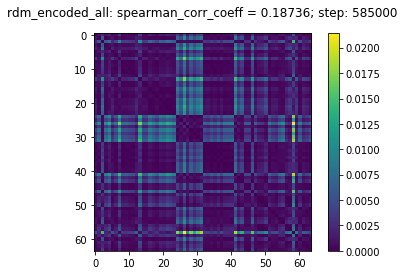

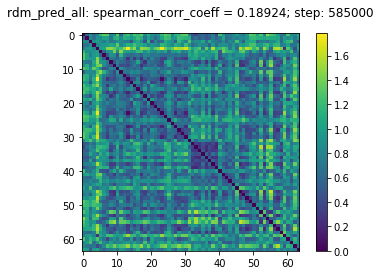

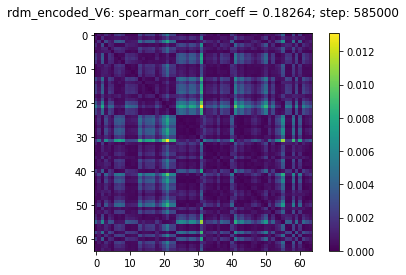

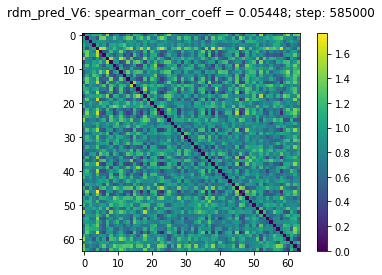

In [6]:
target_layers = ['encoded', 'pred']
exp_id = 'cifar-3'
data = get_neural_validation_data(exp_id, collname, dbname)[-1]['validation_results']['neural']
#print "Model: {0}, training index: {1}".format(collname, idx)
#print "rdms"
step = 585000

plot_rdms(data, target_layers, step, variation='all')
plot_rdms(data, target_layers, step, variation='V6')

### Categorization results
The results of categorization are fairly intuitive. The accuracy of the encoded layer is slightly lower than the predicted (recreated) layer. This is logical as the encoded version is a compressed representation, so it's also good that this encoded version doesn't lose much accuracy to the predicted output.

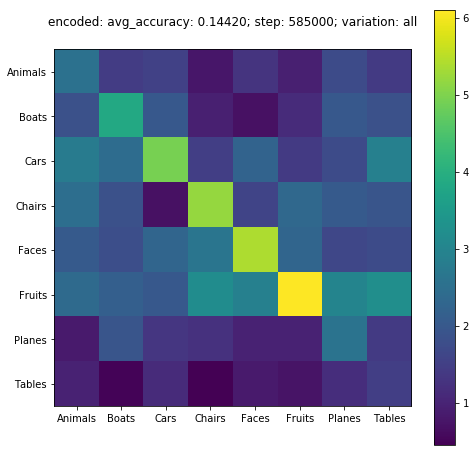

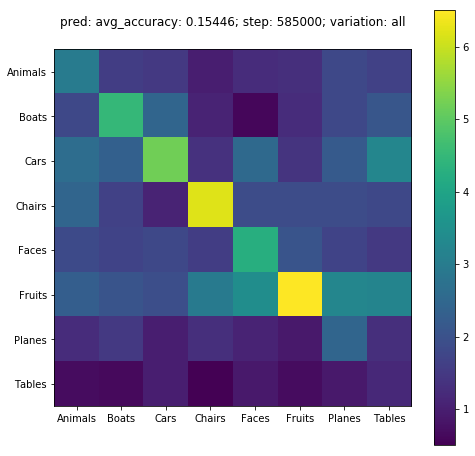

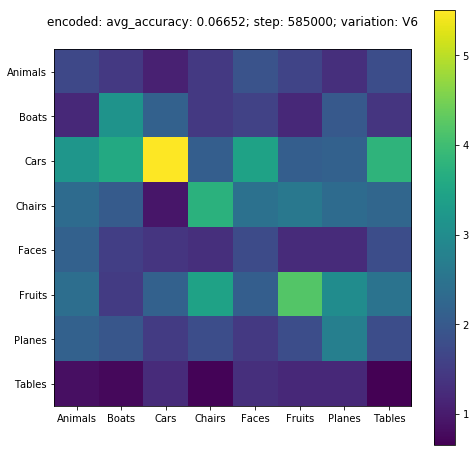

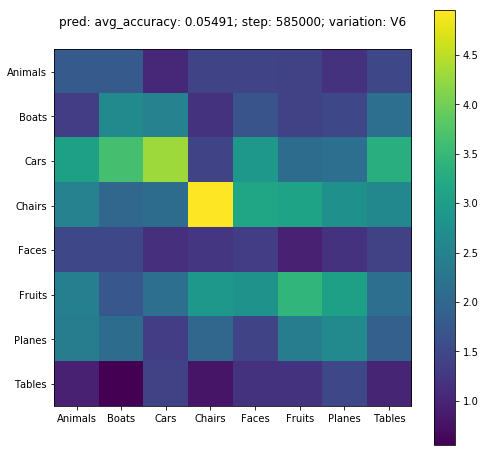

In [7]:
plot_categorization_results(data, target_layers, step, variation='all')
plot_categorization_results(data, target_layers, step, variation='V6')

### Within-category identification

As before, the within-category identification is stronger with the predicted layer, as the encoded representation is essentially a compressed representation of the predicted layer. Again, performance is still somewhat close.

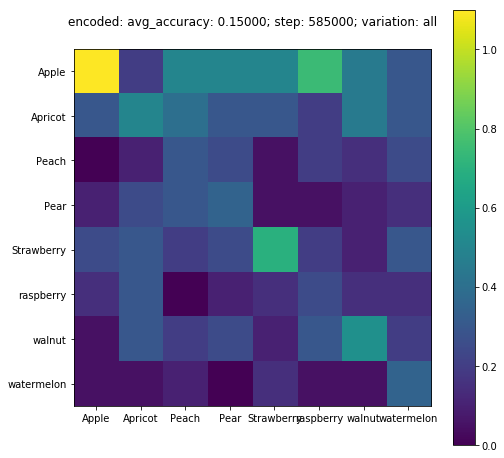

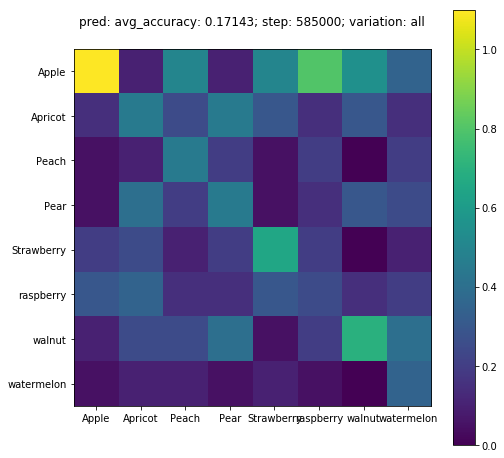

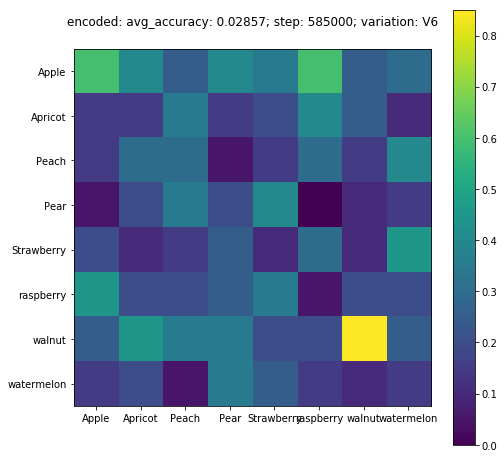

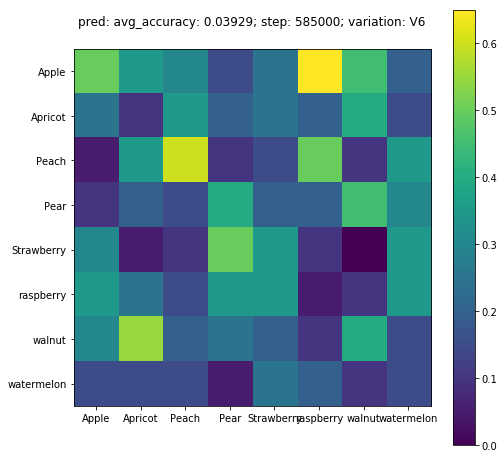

In [8]:
plot_identification_results(data, target_layers, step, variation='all')
plot_identification_results(data, target_layers, step, variation='V6')

### Continuous estimation of ty
Continuous estimation doesn't indicate very strong results here, with the only positive scores coming from all neurons. Therefore, we would believe that this autoencoder isn't encoding images in a similar manner to what the visual cortex may be doing.

In [9]:
plot_estimation_results(data, target_layers, step, variation='all')
plot_estimation_results(data, target_layers, step, variation='V6')

Layer: encoded, variation: all, step: 585000, value: 0.0125594553541
Layer: pred, variation: all, step: 585000, value: 0.00743489769437
Layer: encoded, variation: V6, step: 585000, value: -0.00338054472803
Layer: pred, variation: V6, step: 585000, value: -0.0131190890618


### Regression on IT neurons
For IT, we see a slightly stronger score with the encoding layer than the prediction layer, but they are both weak. This suggests that our encoding layer may actually have some neurons that resemble some IT neurons.

In [10]:
plot_regression_results(data, target_layers, step)

Layer: encoded, step: 585000, value: 0.0632941760544
Layer: pred, step: 585000, value: 0.0456689295412


### Conv-1 kernels
There are only 4 kernels here (the idea was to stack many 3x3 kernels in this model).

Iteration step: 585000


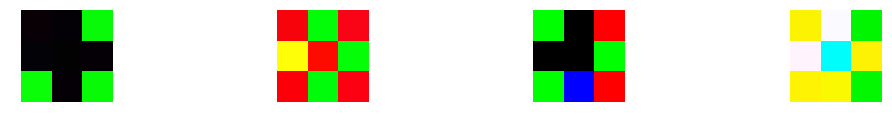

In [11]:
plot_conv1_kernels(data, step)

## Deep Symmetric Autoencoder, earlier training stops
### step 200000

The model has just started training at this point, but already gains some categorization accuracy.
However, the IT regressions have already hit the levels they do at the end of training, which suggests that this model doesn't gradually learn to be similar to IT.

I also included the outputs of additional encoding/decoding layers here. The conv layers are all within the encoder, while the deconv layers are within the decoder. (Not all layers are included as some regressions against very large layers did not terminate.)
For RDMS, the correlation coefficient increases as we get deeper into the encoder, and decreases as we move through the decoder to the reconstructed image. This is actually a good indication for our autoencoder, as it suggests that we are learning something about the image similar to V6 in order to compress it.

The categorization accuracy was actually highest in the earlier layers of the network, likely because we are discarding information in order to compress.

RDMS


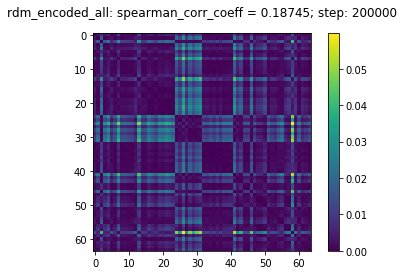

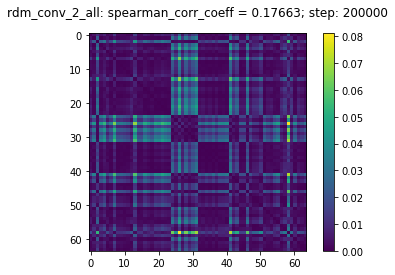

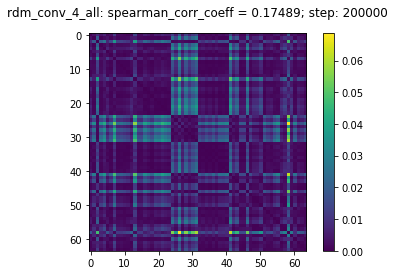

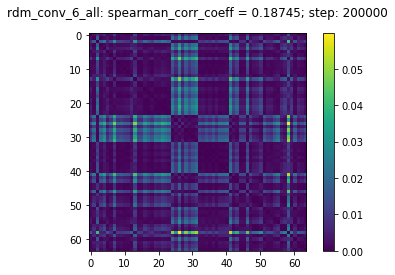

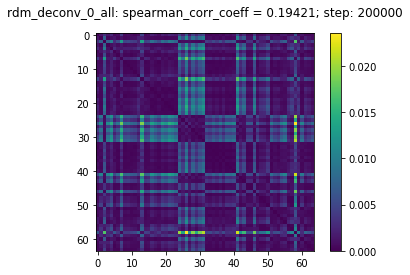

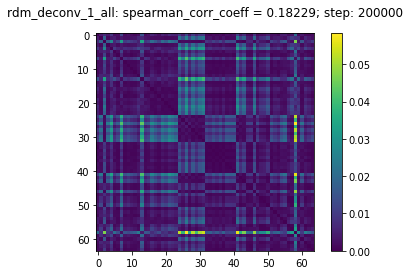

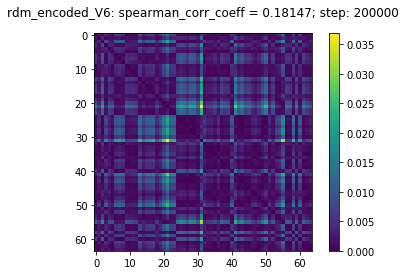

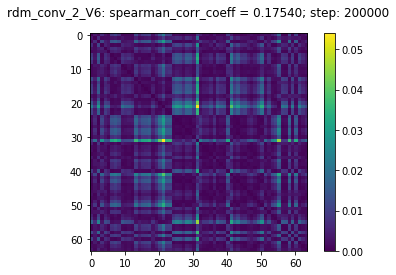

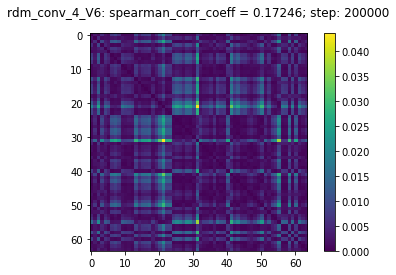

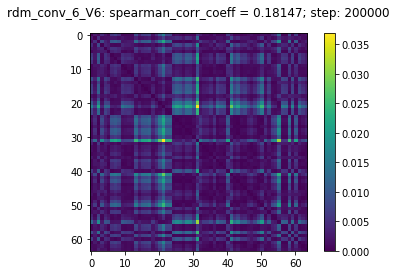

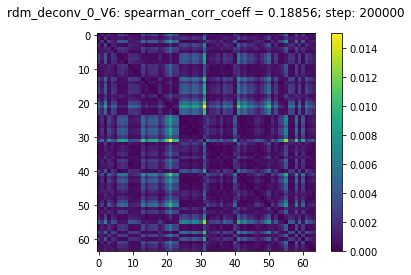

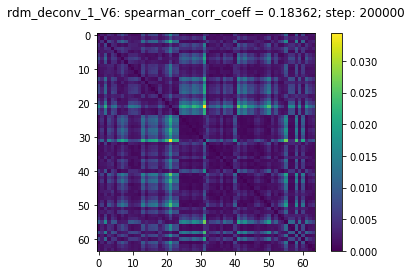

Categorization


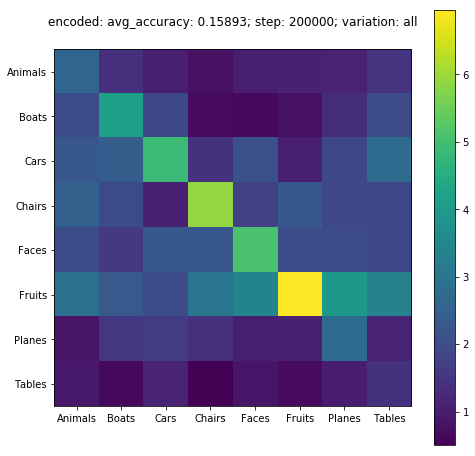

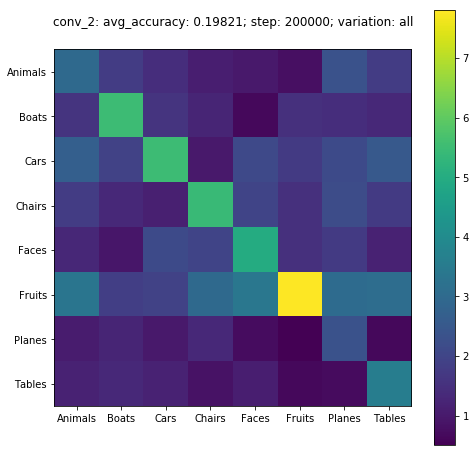

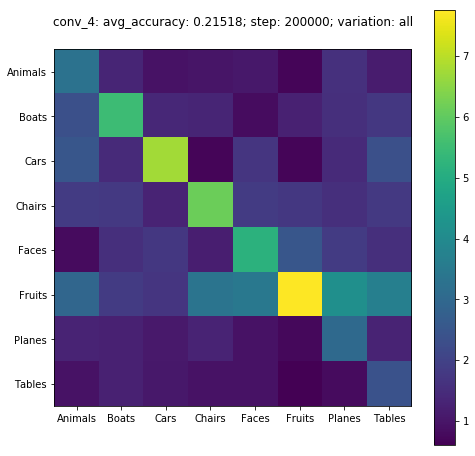

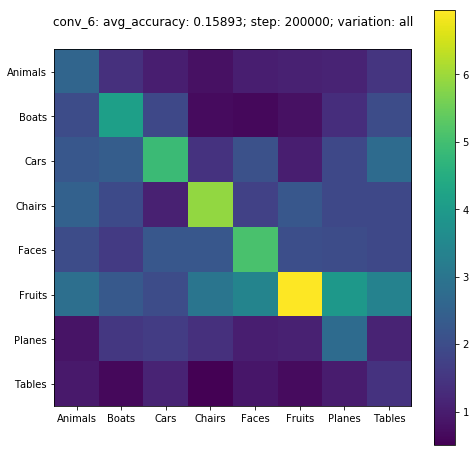

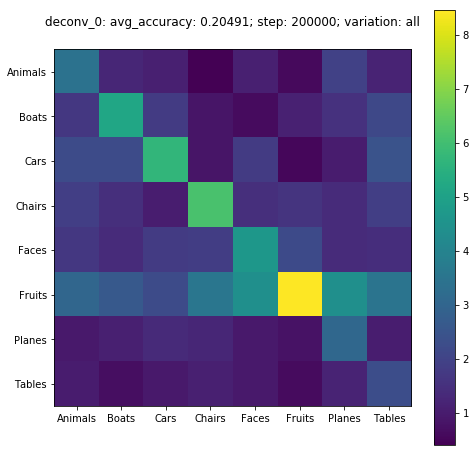

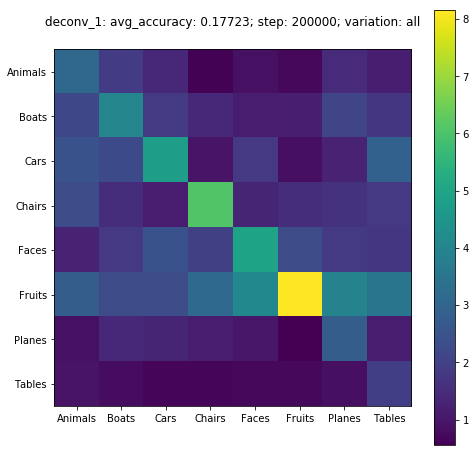

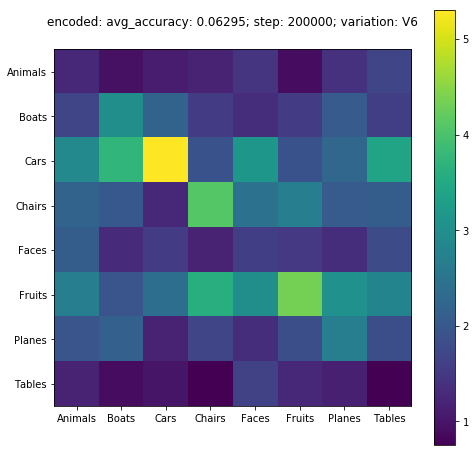

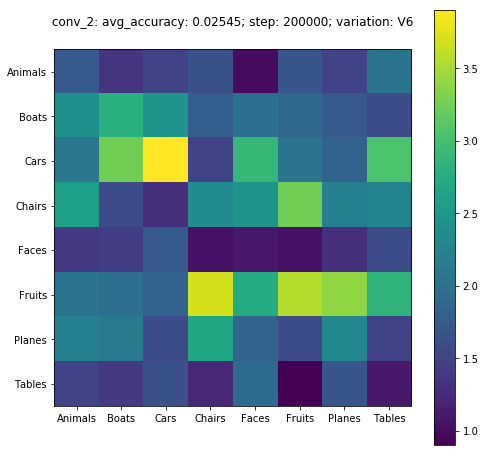

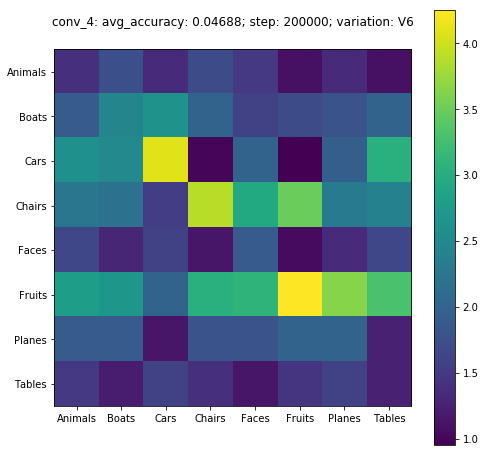

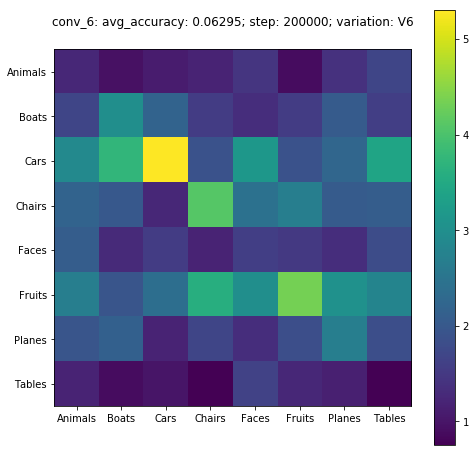

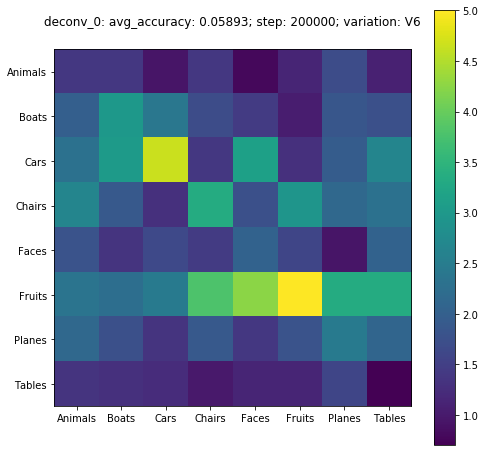

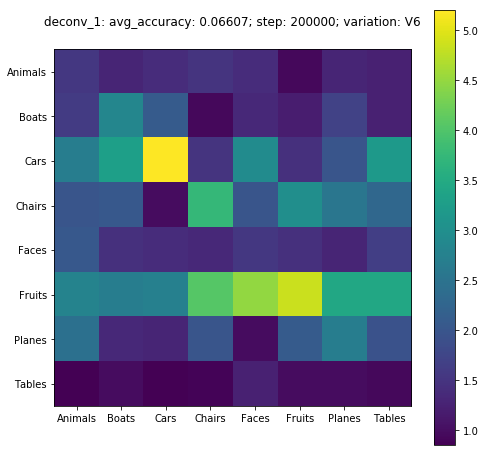

Within Category Identification


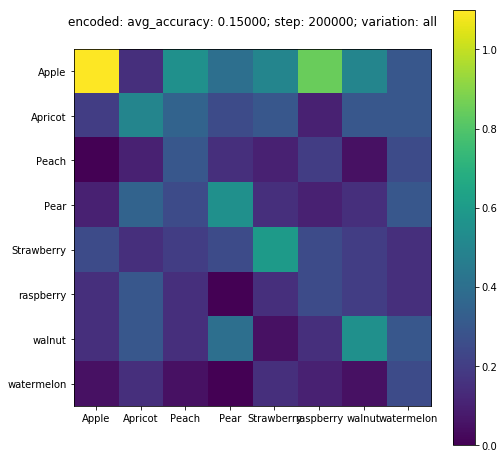

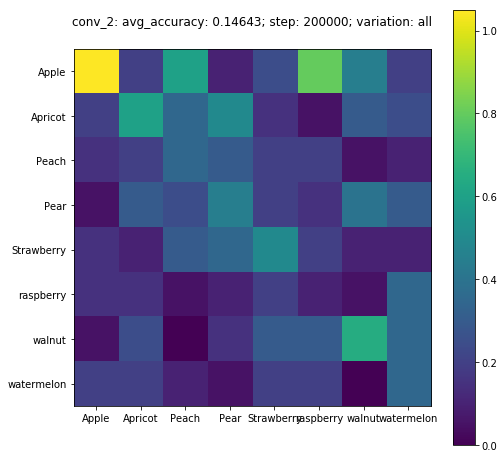

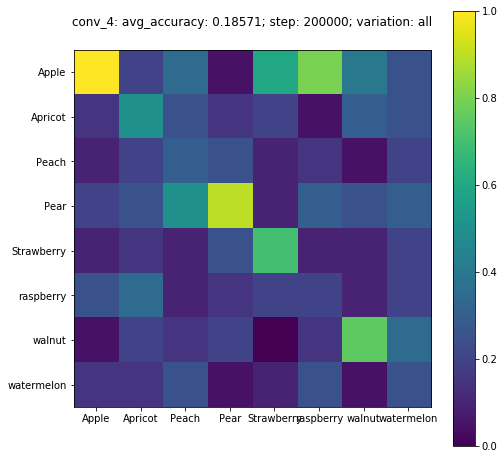

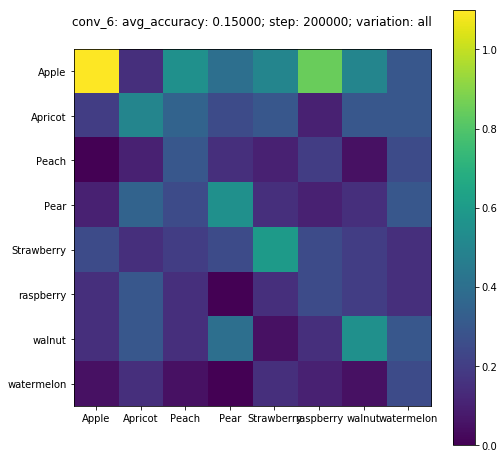

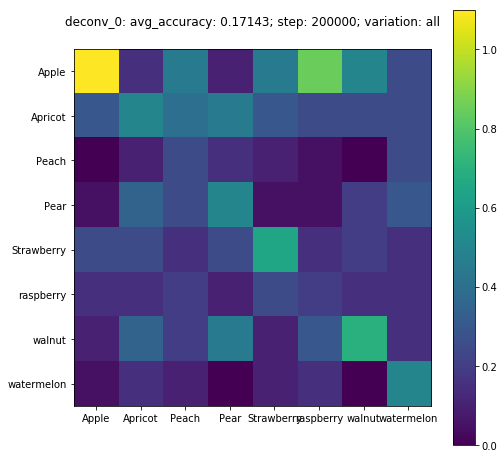

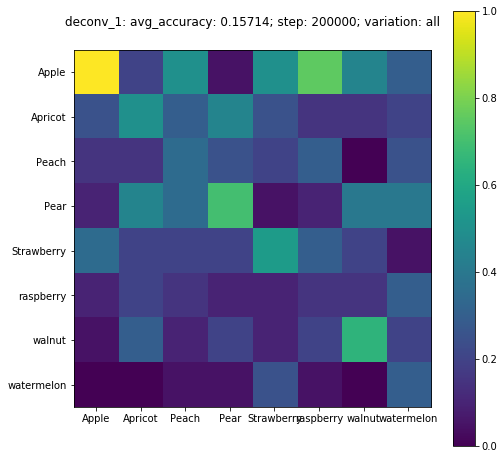

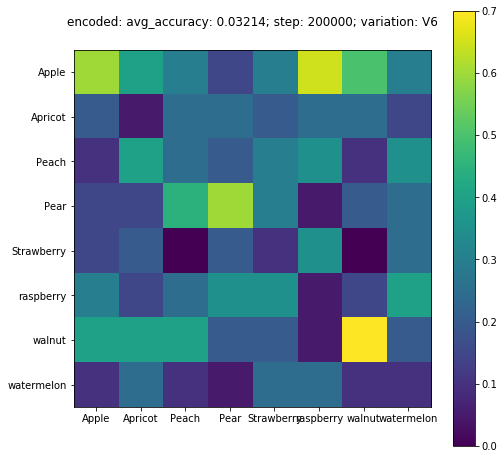

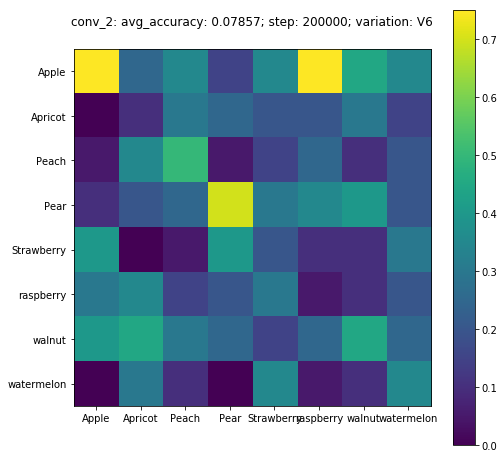

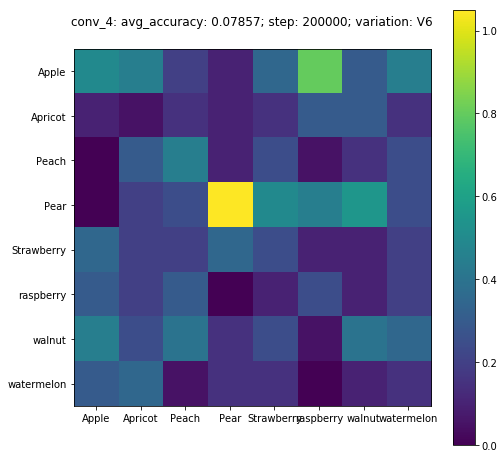

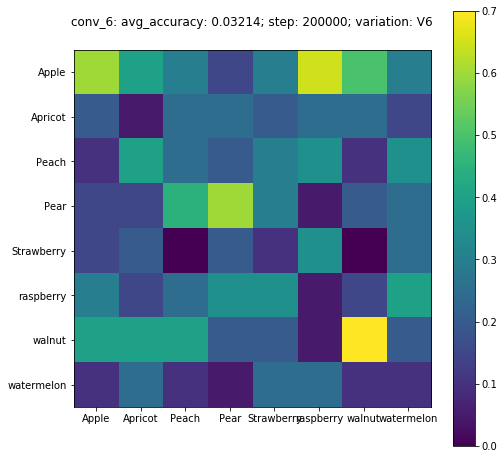

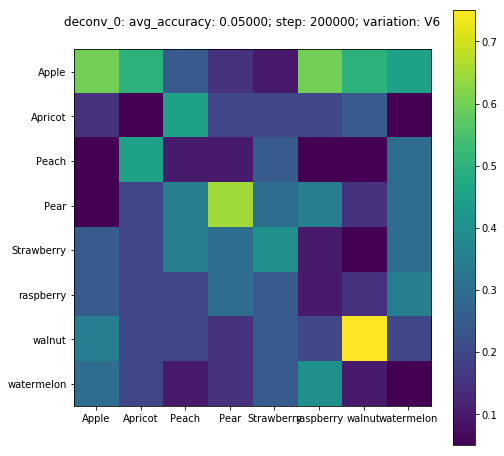

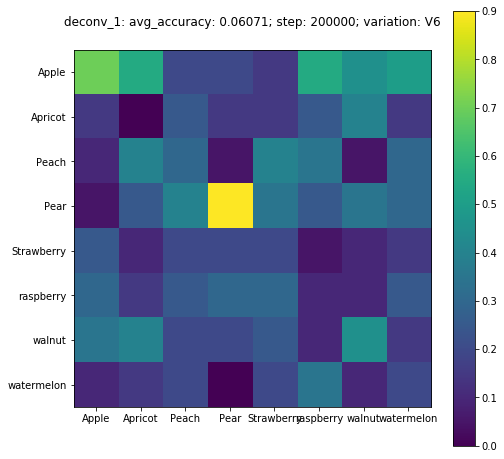

Continuous estimation
Layer: encoded, variation: all, step: 200000, value: 0.00831241543179
Layer: conv_2, variation: all, step: 200000, value: 0.0127812725724
Layer: conv_4, variation: all, step: 200000, value: 0.0172315664678
Layer: conv_6, variation: all, step: 200000, value: 0.00831241543179
Layer: deconv_0, variation: all, step: 200000, value: 0.0144183758861
Layer: deconv_1, variation: all, step: 200000, value: 0.017249448834
Layer: encoded, variation: V6, step: 200000, value: -0.0105785801333
Layer: conv_2, variation: V6, step: 200000, value: -0.00334107017089
Layer: conv_4, variation: V6, step: 200000, value: 0.00294459615515
Layer: conv_6, variation: V6, step: 200000, value: -0.0105785801333
Layer: deconv_0, variation: V6, step: 200000, value: -0.0082202430421
Layer: deconv_1, variation: V6, step: 200000, value: -0.00226595411595
Regression: IT neurons
Layer: encoded, step: 200000, value: 0.0674191420002
Layer: conv_2, step: 200000, value: 0.0701440786294
Layer: conv_4, step: 

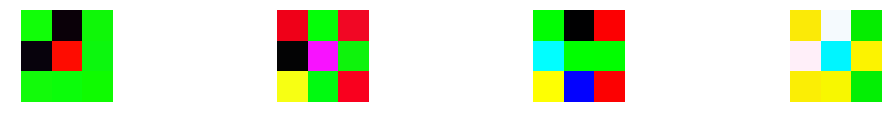

In [12]:
target_layers = ['encoded'] + ['conv_{}'.format(i) for i in range(2, 7, 2)] + ['deconv_{}'.format(i) for i in range(2)]
step = 200000
exp_id = 'cifar-3_%d' % step
data = get_neural_validation_data(exp_id, collname, dbname)[-1]['validation_results']['neural']
print ('RDMS')
plot_rdms(data, target_layers, step, variation='all')
plot_rdms(data, target_layers, step, variation='V6')
print('Categorization')
plot_categorization_results(data, target_layers, step, variation='all')
plot_categorization_results(data, target_layers, step, variation='V6')
print('Within Category Identification')
plot_identification_results(data, target_layers, step, variation='all')
plot_identification_results(data, target_layers, step, variation='V6')
print('Continuous estimation')
plot_estimation_results(data, target_layers, step, variation='all')
plot_estimation_results(data, target_layers, step, variation='V6')
print('Regression: IT neurons')
plot_regression_results(data, target_layers, step)
plot_conv1_kernels(data, step)

# Deep symmetric autoencoder trained on imagenet

This model doesn't perform well on the imagenet task. This is likely due to the size of the model, although increasing the number of filters didn't have a dramatic effect either. We note that the loss does appear flat during training, but because we are not requiring the network to learn classification, and also not providing an abundant number of parameters for the network to tune, the network doesn't have the capacity to extend to imagenet classification.

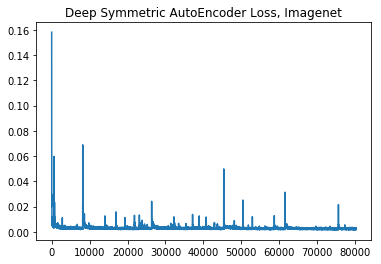

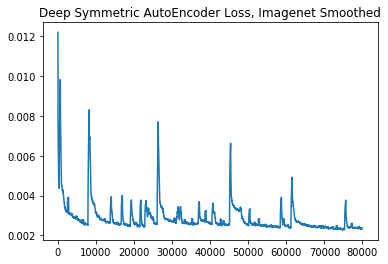

In [13]:
args = ['imagenet-1']
plt_reg_and_smoothed(get_losses(*args), 'Deep Symmetric AutoEncoder Loss, Imagenet')

In [14]:
step = 30000
exp_id = 'imagenet-1_%d' % step
target_layers = ['encoded'] + ['conv_{}'.format(i) for i in range(2, 7, 2)] + ['deconv_{}'.format(i) for i in range(2)]
data = get_classification_validation_data(exp_id, collname, dbname)[-1]['validation_results']['imagenet']
plot_imagenet_results(data, target_layers, step)

encoded: avg_accuracy: 0.01549; step: 30000
conv_2: avg_accuracy: 0.01549; step: 30000
conv_4: avg_accuracy: 0.02020; step: 30000
conv_6: avg_accuracy: 0.01549; step: 30000
deconv_0: avg_accuracy: 0.01751; step: 30000
deconv_1: avg_accuracy: 0.02222; step: 30000


In [15]:
step = 80000
exp_id = 'imagenet-1_%d' % step
data = get_classification_validation_data(exp_id, collname, dbname)[-1]['validation_results']['imagenet']
plot_imagenet_results(data, target_layers, step)

encoded: avg_accuracy: 0.01414; step: 80000
conv_2: avg_accuracy: 0.02155; step: 80000
conv_4: avg_accuracy: 0.02222; step: 80000
conv_6: avg_accuracy: 0.01414; step: 80000
deconv_0: avg_accuracy: 0.02492; step: 80000
deconv_1: avg_accuracy: 0.02963; step: 80000
